# 1. Import Dependencies

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Read MINST Dataset

In [13]:
# Pandas library is used to read only the dataset 
df = pd.read_csv(r"C:\Users\Assem Bahnasy\MINST - Neural Network Performance Test\dataset\train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Building The Neural Network

## 3.1 Data Preparation

In [14]:
# Handling the data by numpy array to make it like a (matrix) to apply the required mathematical calculations
data = np.array(df)
m, n = data.shape # m: number of records (42000); n: number of fields (785)
np.random.shuffle(data) # Shuffling the data so that our results would not be biased by their arrangement

# Data spliting for testing and training
data_test = data[:1000].T # Extracting a division from the dataset of (1000*785) matrix, and transposing it (T) to be (785*1000) matrix
Y_test = data_test[0]   # Data True Labels: Include the first row for labels (i.e., the number inside each image)
X_test = data_test[1:n] # Input data: Include the rest of rows that represent all image pixels
X_test = X_test / 255.  # Data normalization by dividing by max pixel's value (255)

# Specified data for training is taken after the test data division till the last record of dataset
data_train = data[1000:m].T 
Y_train = data_train[0]   # Data True Labels
X_train = data_train[1:n] # Input data
X_train = X_train / 255.  # Data normalization
n_train, _ = X_train.shape

## 3.2 One-hidden Layer Model

### 3.2.1 Activation Functions

In [15]:
def ReLU(Z):
    return np.maximum(0, Z)

# ReLU Derivative
def derivReLU(Z):
    return np.where(Z > 0, 1, 0)

def Softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

### 3.2.2 Prameters Initiation, Forward/Backward Propagations and Parameters Updating

In [16]:
def initParams(n_neurons):
    # weight(1) and bias(1) for the hidden layer of (n) neurons
    # Applying a scaling factor (np.sqrt(1/n)) to help mitigate the vanishing/exploding gradient problems
    W1 = np.random.normal(size=(n_neurons, n_train)) * np.sqrt(1./n_train)
    b1 = np.random.normal(size=(n_neurons, 1)) * np.sqrt(1./n_neurons)
    
    # weight(2) and bias(2) for the output layer of 10 neurons
    W2 = np.random.normal(size=(10, n_neurons)) * np.sqrt(1./n_neurons)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./n_train)
    return W1, b1, W2, b2

def forwardProp(W1, b1, W2, b2, X):
    # Hidden Layer: N neurons
    Z1 = W1.dot(X) + b1 # The dot product between weights and input values + bias 
    A1 = ReLU(Z1) # Activation function for the hidden layer
    
    # Output layer: 10 neurons
    Z2 = W2.dot(A1) + b2 # The dot product between weights and input values + bias
    A2 = Softmax(Z2) # Softmax activation function is used to give probabilities between (0 & 1) for the identified output digit
    return Z1, A1, Z2, A2

# Converting/Encoding digit labels into a one-hot encoded format (i.e., representing categorical class labels as binary vectors)
def oneHot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) # Initialize a 2D NumPy array of zeros 
    one_hot_Y[np.arange(Y.size), Y] = 1 # One-hot encoding step: Assigns 1 to the value in the original array y and all other columns remain 0
    one_hot_Y = one_hot_Y.T # Transposes the one-hot encoded matrix (i.e., column vector)
    return one_hot_Y

def backwardProp(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = oneHot(Y) # Converts the true labels Y into a one-hot encoded matrix
    dZ2 = A2 - one_hot_Y  # Computes the derivative of the loss with respect to the weighted sum of inputs to the second (output) layer
    dW2 = 1 / m * dZ2.dot(A1.T) # Computes the gradient of the loss with respect to the weights of the second (output) layer
    db2 = 1 / m * np.sum(dZ2) # Computes the gradient of the loss with respect to the biases of the second (output) layer
    
    dZ1 = W2.T.dot(dZ2) * derivReLU(Z1) # Computes the derivative of the loss with respect to the weighted sum of inputs to the first (hidden) layer
    dW1 = 1 / m * dZ1.dot(X.T) # Computes the gradient of the loss with respect to the weights of the first (hidden) layer
    db1 = 1 / m * np.sum(dZ1) # Computes the gradient of the loss with respect to the biases of the first (hidden) layer
    return dW1, db1, dW2, db2

def updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1    
    W2 -= alpha * dW2  
    b2 -= alpha * db2
    return W1, b1, W2, b2


### 3.2.3 Gradient Descent, Predictions and Accuracy Optimization

In [17]:
# Give the index of the maximum value along axis 0 (column-wise)
def getPredictions(A2):
    return np.argmax(A2, 0)
    
# Calculate the accuracy of a set of predictions compared to the true labels
def getAccuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradientDescent(X, Y, n_neurons, alpha, iterations):
    W1_list = []
    b1_list = []
    W2_list = []
    b2_list = []
    model_accuracy = []
    
    for neurons in n_neurons:
        W1, b1, W2, b2 = initParams(neurons) # To initiate parameters of the hidden and output layer
        iteration_list = []  # To store iteration numbers
        accuracy_list = []   # To store corresponding accuracies
        print('\nHidden Layer: '+ str(neurons) + ' Neurons\n' + 25*'*')
        for i in range(iterations):
            Z1, A1, Z2, A2 = forwardProp(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = backwardProp(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = updateParams(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
            
            if i % 10 == 0:
                print(f"Iteration: {i + 10}")
                iteration_list.append(i + 10)
                predictions = getPredictions(A2) 
                print(predictions, Y)
                accuracy = getAccuracy(predictions, Y)
                accuracy_list.append(accuracy)
                print(f"Accuracy: {accuracy * 100:.2f}%")
                
        W1_list.append(W1)
        b1_list.append(b1)
        W2_list.append(W2)
        b2_list.append(b2)
        model_accuracy.append(accuracy_list)
        
    return W1_list, b1_list, W2_list, b2_list, model_accuracy, iteration_list

# 4. Neural Network Training with Variable Hidden Layer Neurons

In [18]:
n_neurons = [8, 10, 16, 32, 64] # Specified number of neurons in the hidden layer
iterations = 400 # Specified number of iterations
alpha = 0.10 # Specified training rate

X = X_train # Trained data
Y = Y_train # Data True labels

W1_list = []
b1_list = []
W2_list = []
b2_list = []
model_accuracy = []

W1_list, b1_list, W2_list, b2_list, model_accuracy, iteration_list = gradientDescent(X, Y, n_neurons, alpha, iterations)


Hidden Layer: 8 Neurons
*************************
Iteration: 10
[3 4 5 ... 4 4 8] [4 1 9 ... 3 5 0]
Accuracy: 9.29%
Iteration: 20
[8 1 4 ... 3 4 8] [4 1 9 ... 3 5 0]
Accuracy: 36.84%
Iteration: 30
[3 1 4 ... 3 4 8] [4 1 9 ... 3 5 0]
Accuracy: 43.47%
Iteration: 40
[3 1 4 ... 3 4 8] [4 1 9 ... 3 5 0]
Accuracy: 45.13%
Iteration: 50
[0 1 4 ... 3 4 8] [4 1 9 ... 3 5 0]
Accuracy: 48.63%
Iteration: 60
[0 1 4 ... 3 4 2] [4 1 9 ... 3 5 0]
Accuracy: 53.58%
Iteration: 70
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 59.11%
Iteration: 80
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 62.47%
Iteration: 90
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 65.42%
Iteration: 100
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 69.23%
Iteration: 110
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 72.90%
Iteration: 120
[0 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 75.57%
Iteration: 130
[5 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 77.81%
Iteration: 140
[5 1 4 ... 3 5 2] [4 1 9 ... 3 5 0]
Accuracy: 79.58%
Iterati

# 5. Model Performance Viualization

## 5.1 Models Accuracy Per Number of Neurons

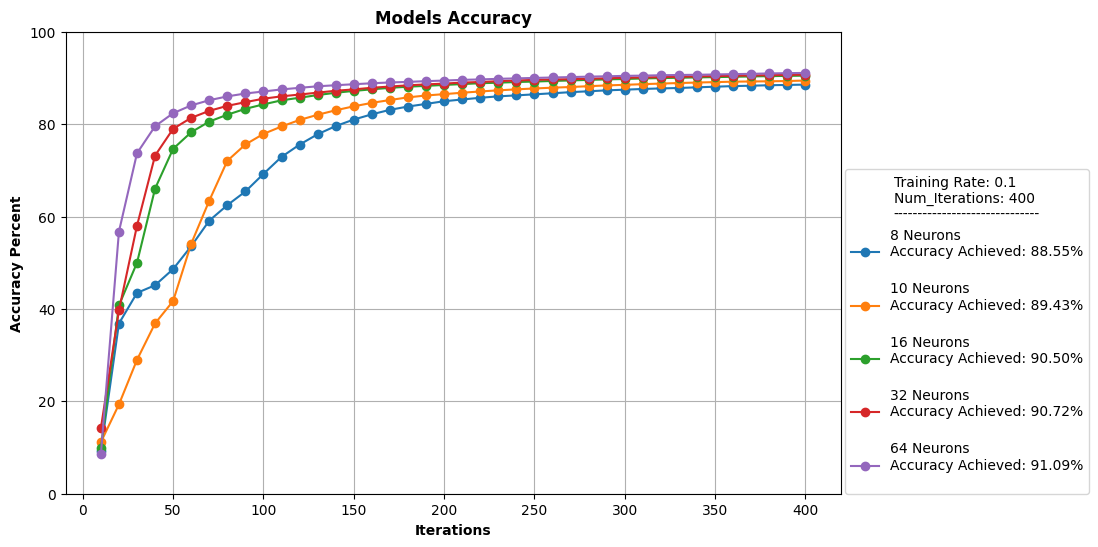

In [19]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

for i, accuracy in enumerate(model_accuracy):
    plt.plot(iteration_list, np.array(accuracy) * 100, marker='o',
             label=str(n_neurons[i])+ f' Neurons\nAccuracy Achieved: {model_accuracy[i][-1] * 100:.2f}%\n')
plt.title('Models Accuracy', weight='bold')
plt.xlabel('Iterations', weight='bold')
plt.ylabel('Accuracy Percent', weight='bold')
plt.ylim(0, 100)  # Set y-axis limits
plt.grid(True)  # Add grids

# Adding legend
legend_title = 'Training Rate: '+str(alpha)+'\nNum_Iterations: '+str(iterations)+'\n'+30*'-'
plt.legend(title=legend_title, loc='lower right', bbox_to_anchor=(1.32, 0), borderaxespad=0., ncol=1)

# Save the chart as a PNG file
plt.savefig('Models-Accuracies.png', bbox_inches='tight')

plt.show()

## 5.2 Visualize Models Predictions

In [20]:
def makePredictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forwardProp(W1, b1, W2, b2, X)
    predictions = getPredictions(A2)
    return predictions

def testPrediction(neurons, W1_list, b1_list, W2_list, b2_list):
    n = 0 # Counter to save the predicted labels of each hidden layer
    
    for i in range(len(neurons)):
        print('Hidden Layer: '+ str(neurons[i]) + ' Neurons\n' + 25*'*')
        
        # Create a dictionary of 25 images
        image_dict = {}
        
        for index in range(25):
            image = X_train[:, index, None]
            prediction = makePredictions(X_train[:, index, None], W1_list[i], b1_list[i], W2_list[i], b2_list[i])
            label = Y_train[index]
            image_dict[str(index)] = (image, prediction, label)

        # Display the images in a 5x5 grid
        fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

        for i in range(5):
            for j in range(5):
                # Get image and label from the dictionary
                key = i * 5 + j
                image, prediction, label = image_dict[str(key)]
                
                # Reshape and scale the current image
                image = image.reshape((28, 28))
                
                # Display the image on the current subplot
                axes[i, j].imshow(image, cmap='gray', interpolation='nearest')
                axes[i, j].axis('off')  # Turn off axis labels for clarity
            
                # Add text with label and number
                text = f"Prediction: {prediction}\nLabel: {label}"
                axes[i, j].text(0.5, -0.1, text, 
                                transform=axes[i, j].transAxes,
                                horizontalalignment='center', verticalalignment='center', 
                                fontsize=8)
            if i == 4 and j == 4:
                # Adding text
                text = str(neurons[n])+' Neurons Hidden Layer\n'+36*'-'+'\nTraining Rate: '+str(alpha)+'\nNum_of_Iterations: '+str(iterations)
                text_box = plt.text(0.91, 0.815, text, bbox=dict(facecolor='lightgray', alpha=0.5),
                                    transform=plt.gcf().transFigure)
                # Save the chart as a PNG file
                plt.savefig('Test-Predictions-of-'+str(neurons[n])+'-Neurons.png', bbox_inches='tight')
                n = n + 1
        
        plt.show()

Hidden Layer: 8 Neurons
*************************


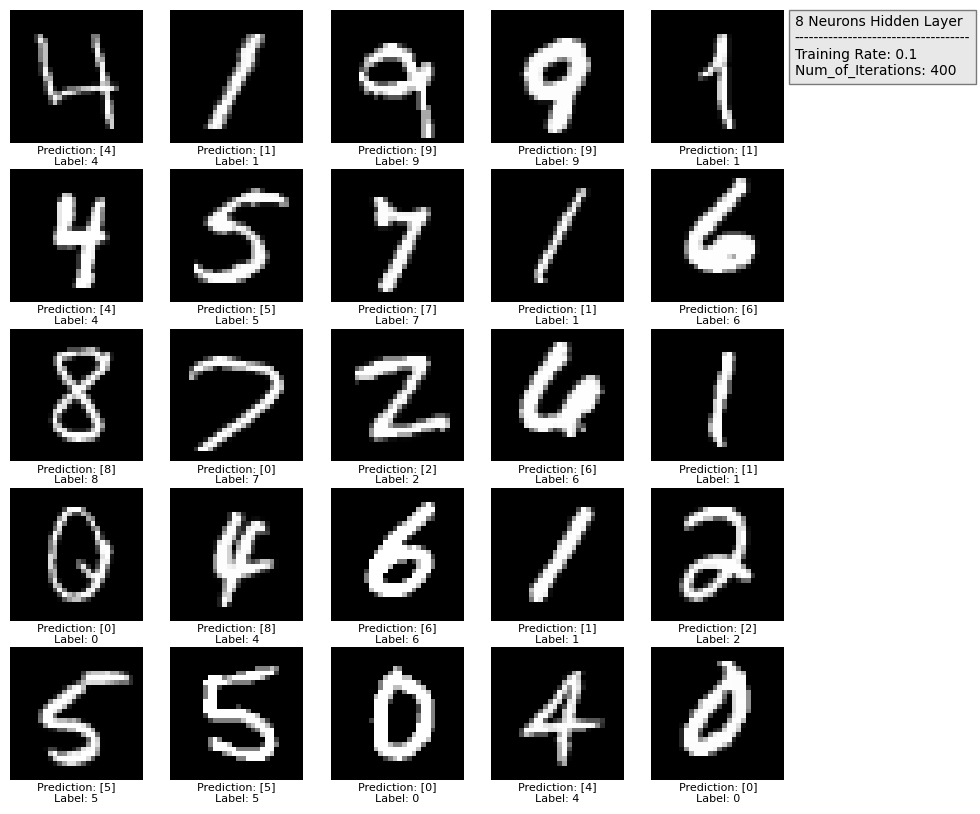

Hidden Layer: 10 Neurons
*************************


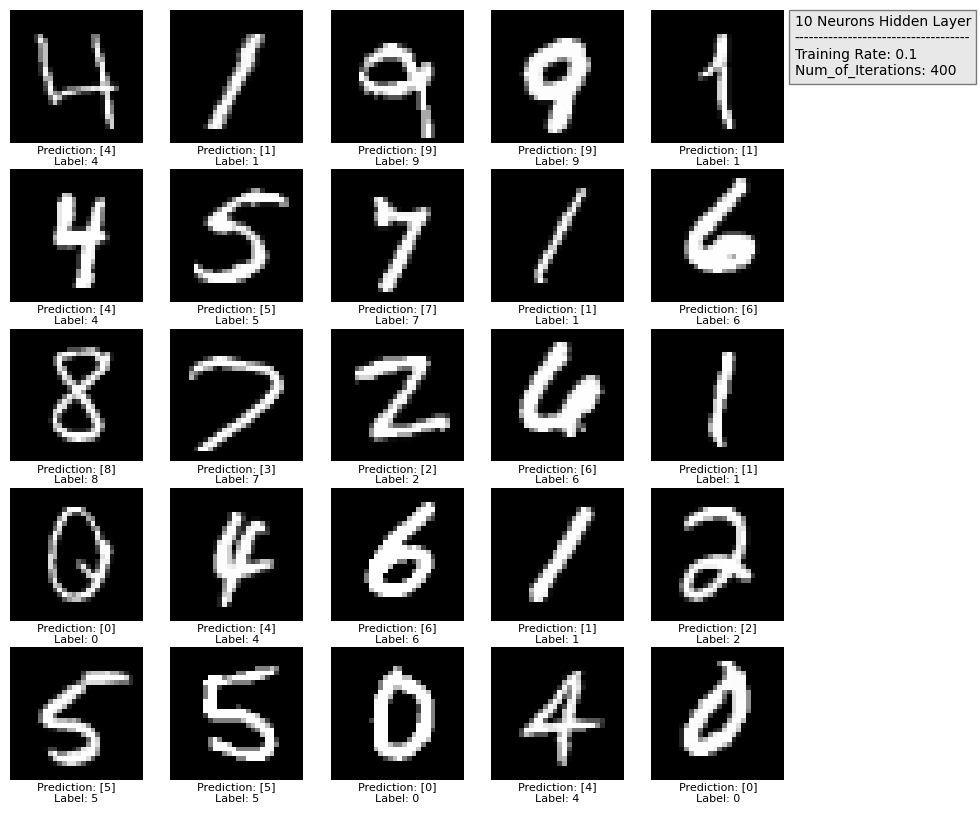

Hidden Layer: 16 Neurons
*************************


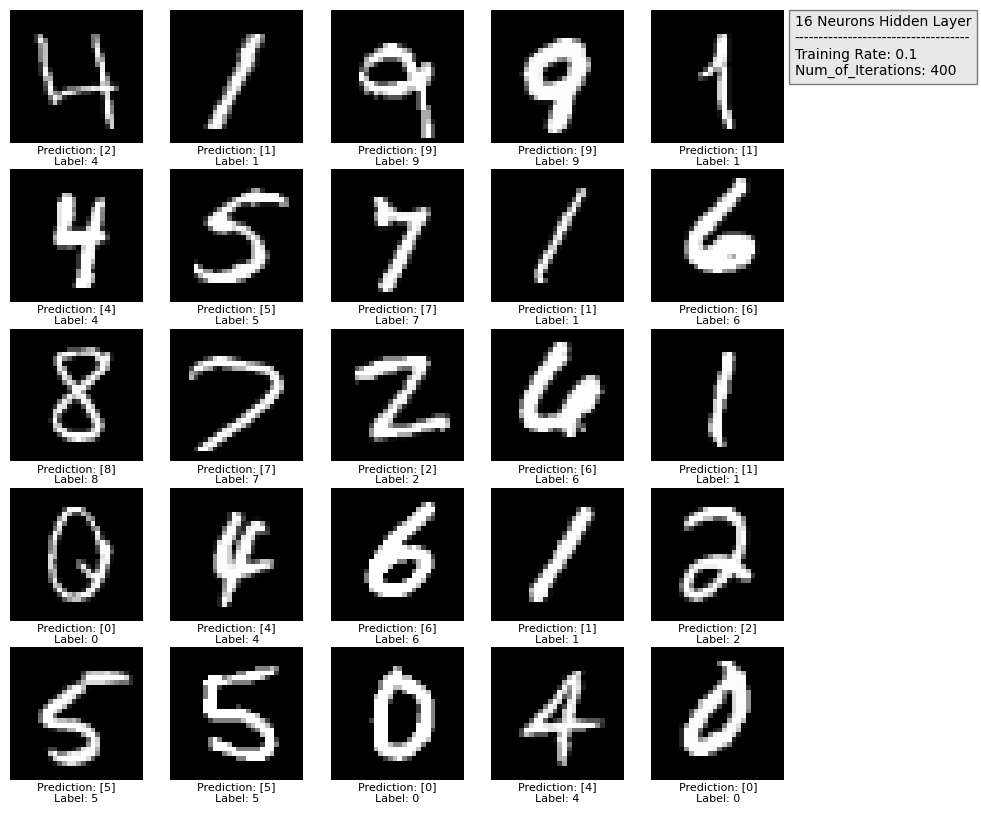

Hidden Layer: 32 Neurons
*************************


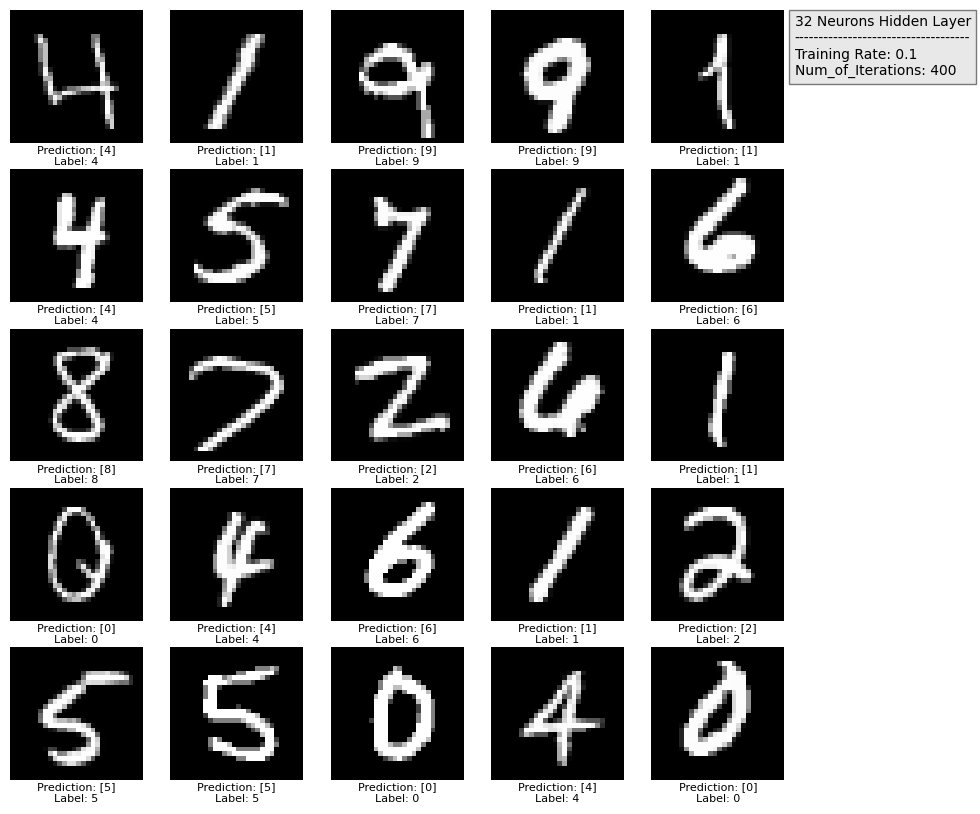

Hidden Layer: 64 Neurons
*************************


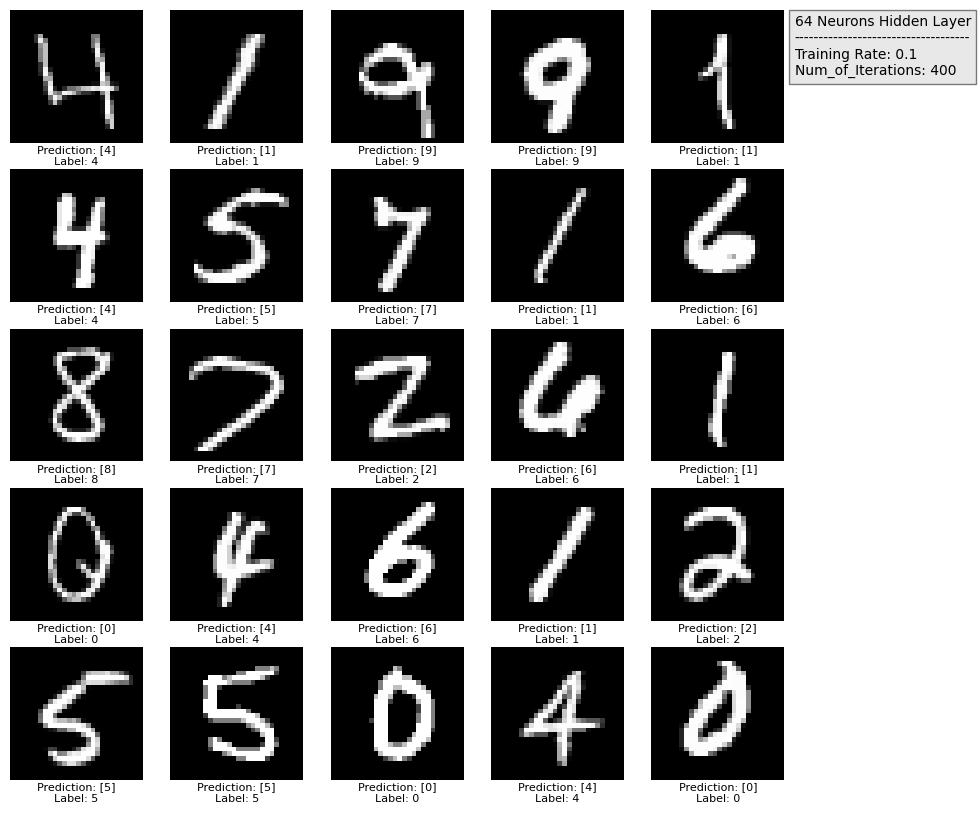

In [21]:
testPrediction(n_neurons, W1_list, b1_list, W2_list, b2_list)

## 5.3 Test Models Accuracies

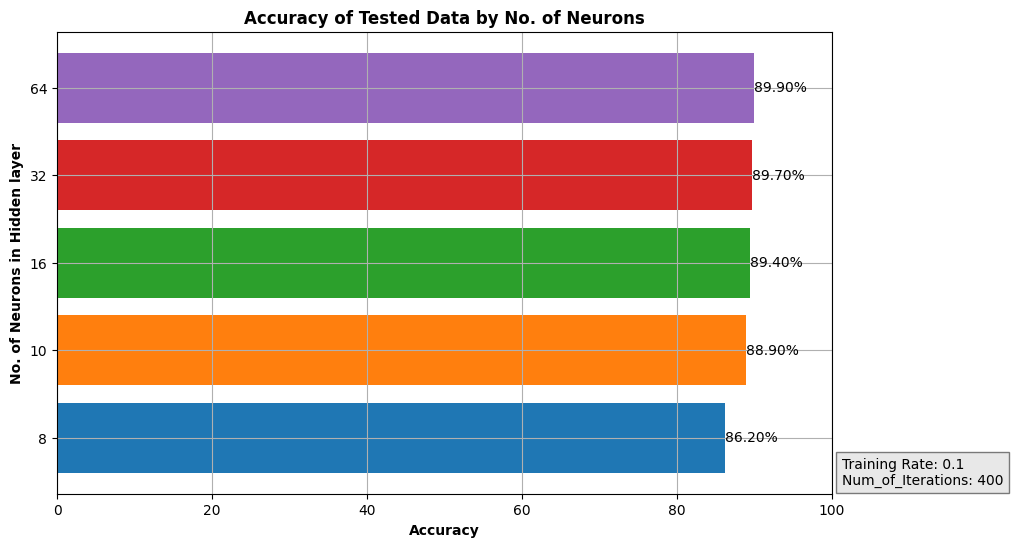

In [22]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

neurons = []
accuracies = []

for i, neuron in enumerate(n_neurons):
    neurons.append(str(neuron))
    test_predictions = makePredictions(X_test, W1_list[i], b1_list[i], W2_list[i], b2_list[i])
    accuracies.append(getAccuracy(test_predictions, Y_test) * 100)

# Create a horizontal bar chart
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(neurons))]
bars = plt.barh(neurons, accuracies, color=colors)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{accuracy:.2f}%', 
             ha='left', va='center', color='black')

# Set title and labels
plt.title('Accuracy of Tested Data by No. of Neurons', weight='bold')
plt.ylabel('No. of Neurons in Hidden layer', weight='bold')
plt.xlabel('Accuracy', weight='bold')
plt.xlim(0, 100)  # Set x-axis limits
plt.grid(True)  # Add grids

# Adding text with the value of the training rate and no. of iterations
text = 'Training Rate: '+str(alpha)+'\nNum_of_Iterations: '+str(iterations)
text_box = plt.text(0.91, 0.125, text, bbox=dict(facecolor='lightgray', alpha=0.5),
                    transform=plt.gcf().transFigure)

# Save the chart as a PNG file
plt.savefig('Tested-Data-Accuracy-vs-Neurons.png', bbox_inches='tight')

plt.show()